In [16]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from tensorflow import keras

Processing sound categories: 100%|██████████| 12/12 [08:35<00:00, 42.99s/it]


X_data shape: (29847, 128, 52)
y_data shape: (29847,)
First 10 labels in y_data: ['cough' 'cough' 'cough' 'cough' 'cough' 'cough' 'cough' 'cough' 'cough'
 'cough']


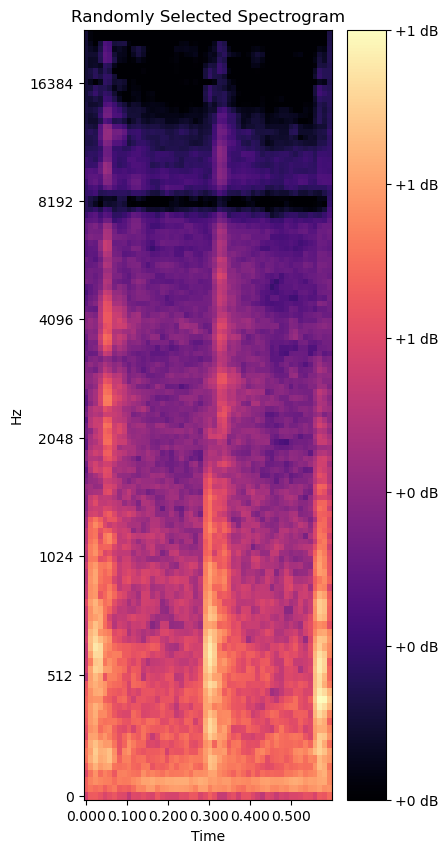

Selected y label: running_outdoor


In [2]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from tqdm import tqdm

# 루트 디렉토리 경로
root_directory = '/Users/jaeyoung/creamo/ClapNet/data/174.자연 및 인공적 발생 非언어적 소리 데이터/01.데이터/1.Training/원천데이터/TS_3.사람'

# 처리할 소리 데이터와 라벨
sound_labels = {
    '1.생리현상/1.기침': 'cough',
    '1.생리현상/2.트림': 'burp',
    '1.생리현상/3.방귀': 'fart',
    '1.생리현상/4.재채기': 'sneeze',
    '2.신체를 이용한 인위적 소리/1.박수': 'clap',
    '2.신체를 이용한 인위적 소리/3.휘파람': 'whistle',
    '3.감정/1.웃음': 'laughter',
    '3.감정/2.울음': 'crying',
    '3.감정/3.비명': 'scream',
    '4.이동감지/1.실외에서 걸으면서 이동하는 소리': 'walking_outdoor',
    '4.이동감지/2.밟는소리': 'footstep',
    '4.이동감지/3.실외에서 뛰면서 이동하는 소리': 'running_outdoor',
}

# 윈도우 크기 및 기타 설정
window_duration = 0.6  # 초
hop_length = 512  # 기본 hop length
window_size = None
minimum_distance = None
sr = None  # 샘플링 레이트

# 데이터 저장용 리스트 초기화
X_data = []
y_data = []

def process_audio_files(directory, label):
    global window_size, sr, minimum_distance
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.mp3'):
                file_paths.append(os.path.join(root, file))

    for file_path in tqdm(file_paths, desc=f'Processing {label} files'):
        y, sr = librosa.load(file_path, sr=None)
        start_time = 8
        start_sample = int(start_time * sr)
        y_trimmed = y[start_sample:]
        y_trimmed_db = librosa.amplitude_to_db(np.abs(y_trimmed), ref=np.max)
        threshold_db = -20
        indices = np.where(y_trimmed_db > threshold_db)[0]

        if window_size is None:
            window_size = int(window_duration * sr)
            minimum_distance = int(0.6 * sr)
        
        last_index = -minimum_distance

        for i, idx in enumerate(indices):
            if idx - last_index >= minimum_distance:
                start_idx = max(0, idx - window_size // 2)
                end_idx = min(len(y_trimmed), idx + window_size // 2)
                y_window = y_trimmed[start_idx:end_idx]
                S_window = librosa.feature.melspectrogram(y=y_window, sr=sr, n_mels=128, hop_length=hop_length)
                S_window_dB = librosa.power_to_db(S_window, ref=np.max)
                S_window_dB_normalized = (S_window_dB - np.min(S_window_dB)) / (np.max(S_window_dB) - np.min(S_window_dB))

                # 스펙트로그램의 크기를 확인하고 패딩 적용
                target_width = (window_size // hop_length) + 1
                if S_window_dB_normalized.shape[1] < target_width:
                    padding = target_width - S_window_dB_normalized.shape[1]
                    S_window_dB_normalized = np.pad(S_window_dB_normalized, ((0, 0), (0, padding)), mode='constant')
                
                X_data.append(S_window_dB_normalized)
                y_data.append(label)
                last_index = idx

# 모든 소리 데이터를 처리
for subdir, label in tqdm(sound_labels.items(), desc='Processing sound categories'):
    directory = os.path.join(root_directory, subdir)
    process_audio_files(directory, label)

# numpy 배열로 변환
X_data = np.array(X_data)
y_data = np.array(y_data)

# 데이터 저장
np.save('X_train.npy', X_data)
np.save('y_train.npy', y_data)

# 데이터 크기 확인
print(f'X_data shape: {X_data.shape}')
print(f'y_data shape: {y_data.shape}')

# y_data의 처음 10개 값 출력
print('First 10 labels in y_data:', y_data[:10])

# 무작위로 1개의 스펙트로그램 선택 및 시각화
import random
random_idx = random.choice(range(X_data.shape[0]))

# 시각화
fig, ax = plt.subplots(figsize=(4, 10))  # 세로로 긴 형태로 설정
img = librosa.display.specshow(X_data[random_idx], sr=sr, x_axis='time', y_axis='mel', ax=ax)
cbar = fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Randomly Selected Spectrogram')

# 이미지를 저장합니다 (선택 사항)
plt.savefig('random_spectrogram_long.png', bbox_inches='tight', pad_inches=0)
plt.show()

# 해당 y 라벨 프린트
print('Selected y label:', y_data[random_idx])


X_data shape: (29847, 128, 52)
y_data shape: (29847,)


NameError: name 'sr' is not defined

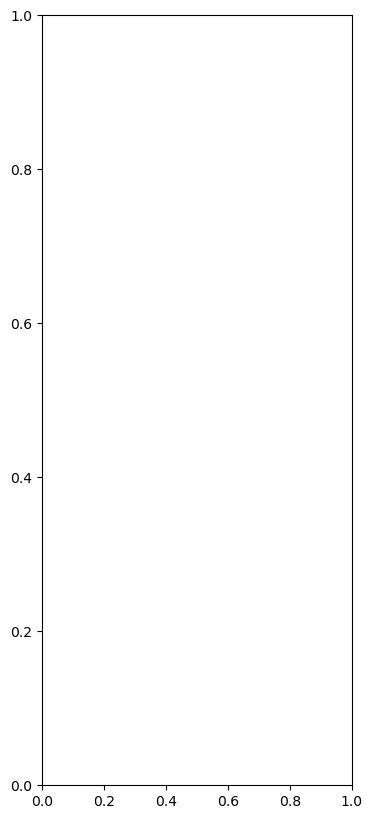

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import random

# 데이터 로드
X_data_padded = np.load('X_train.npy')
y_data = np.load('y_train.npy')

# 데이터 크기 확인
print(f'X_data shape: {X_data_padded.shape}')
print(f'y_data shape: {y_data.shape}')

# 무작위로 하나의 인덱스 선택
random_idx = random.randint(0, X_data_padded.shape[0] - 1)

# 선택된 스펙트로그램과 라벨 가져오기
selected_X = X_data_padded[random_idx]
selected_y = y_data[random_idx]

# 선택된 스펙트로그램 이미지로 시각화
fig, ax = plt.subplots(figsize=(4, 10))  # 세로로 긴 형태로 설정
img = librosa.display.specshow(selected_X, sr=sr, x_axis='time', y_axis='mel', ax=ax)
cbar = fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Randomly Selected Spectrogram')

# 이미지를 저장합니다 (선택 사항)
print('Selected y label:', selected_y)

plt.savefig('random_spectrogram_long.png', bbox_inches='tight', pad_inches=0)
plt.show()

# 해당 y 라벨 프린트


In [8]:
independent = np.load('X_train.npy')
independent = independent.reshape(independent.shape[0], independent.shape[1], independent.shape[2], 1)

independent.shape

(29847, 128, 52, 1)

In [9]:
dependent = np.load('y_train.npy')
dependent.shape

(29847,)

In [13]:
dependent = pd.get_dummies(dependent)
dependent = dependent.astype(int)
dependent.shape

(29847, 12)

In [14]:
print(dependent.tail())

       burp  clap  cough  crying  fart  footstep  laughter  running_outdoor  \
29842     0     0      0       0     0         0         0                1   
29843     0     0      0       0     0         0         0                1   
29844     0     0      0       0     0         0         0                1   
29845     0     0      0       0     0         0         0                1   
29846     0     0      0       0     0         0         0                1   

       scream  sneeze  walking_outdoor  whistle  
29842       0       0                0        0  
29843       0       0                0        0  
29844       0       0                0        0  
29845       0       0                0        0  
29846       0       0                0        0  


In [19]:
import tensorflow as tf

# Define the model
X = tf.keras.layers.Input(shape=[128, 52, 1])
H = tf.keras.layers.Conv2D(3, kernel_size=5, activation='swish')(X)
H = tf.keras.layers.Conv2D(6, kernel_size=5, activation='swish')(H)
H = tf.keras.layers.Flatten()(H)
H = tf.keras.layers.Dense(84, activation='swish')(H)
Y = tf.keras.layers.Dense(12, activation='softmax')(H)

model = tf.keras.models.Model(X, Y)

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
model.fit(independent, dependent, epochs=10)

Epoch 1/10
933/933 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.6510 - loss: 1.0758
Epoch 2/10
933/933 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.8586 - loss: 0.4111
Epoch 3/10
933/933 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.9102 - loss: 0.2678
Epoch 4/10
933/933 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.9442 - loss: 0.1696
Epoch 5/10
933/933 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.9697 - loss: 0.0960
Epoch 6/10
933/933 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.9866 - loss: 0.0460
Epoch 7/10
933/933 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.9935 - loss: 0.0241
Epoch 8/10
933/933 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.9967 - loss: 0.0154
Epoch 9/10
933/933 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.9966 - loss: 0.0127
Epoch 10/10
933/933 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.9981 - loss: 0.0070


In [27]:
pred = model.predict(independent[3483:3500])
pd.DataFrame(pred).round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,0.0,0.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0
5,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
6,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
7,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
8,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
9,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [28]:
dependent[3483:3500]

,burp,clap,cough,crying,fart,footstep,laughter,running_outdoor,scream,sneeze,walking_outdoor,whistle
3483,0,1,0,0,0,0,0,0,0,0,0,0
3484,0,1,0,0,0,0,0,0,0,0,0,0
3485,0,1,0,0,0,0,0,0,0,0,0,0
3486,0,1,0,0,0,0,0,0,0,0,0,0
3487,0,1,0,0,0,0,0,0,0,0,0,0
3488,0,1,0,0,0,0,0,0,0,0,0,0
3489,0,1,0,0,0,0,0,0,0,0,0,0
3490,0,1,0,0,0,0,0,0,0,0,0,0
3491,0,1,0,0,0,0,0,0,0,0,0,0
3492,0,1,0,0,0,0,0,0,0,0,0,0
